## Evaluation Plan
1. Synthetic Data - Generate data with Noise
    i. Figure: 4 Plots - training_data, mc_dropout, concrete_dropout, mc_alpha  
    ii. Figure: (x-axis) confidence interval vs (y-axis) percentage of samples in interval   
2. Climate Downscaling Dataset (eval on test set)  
    i. Table: RMSE, Corr, Prediction intervals  
    ii. Figure: True vs Prediction, Distribution of samples for an extreme  


In [81]:
import sys
import numpy as np
import tensorflow as tf
from models import ConcreteDropout, KerasMCDropout, smooth

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Polygon
import seaborn as sns
import scipy.stats 
import pandas as pd
from sklearn.preprocessing import StandardScaler 

import keras.backend as K
from keras import initializers, regularizers, optimizers
from keras import layers
from keras.layers import Input, Dense, Lambda, merge, Conv2D, MaxPooling2D, Flatten, Dropout, Wrapper
from keras.models import Model, Sequential, load_model
from keras.engine import InputSpec

eps = 1e-8

sns.set_context("paper", font_scale=1.5)
np.random.seed(0)

# Set some global parameters

In [82]:
K_test = 5
batch_size = 128
lr = 1e-4
default_dropout_rate = 0.5
alpha = 0.5
layer_sizes=[128,128,]

# MC-Dropout

## Dropout with Alpha-Divergence Loss

### General Loss function
$\mathcal{L}(\Theta) = \dfrac{1}{\alpha} \sum_n \text{log-sum-exp}\big[ -\alpha * l(y_n, f^{\hat{\omega}_k}(x_n)) \big] + L_2(\Theta)$

### Regression Loss
$l(y, f^{\hat{\omega}_k}(x_n)) = \dfrac{1}{2}||y - f^{\hat{\omega}_k}(x)||_2^2$

### Regression Alpha-Divergence Loss
$\mathcal{L}(\Theta) = -\dfrac{1}{\alpha} \sum_n \text{log-sum-exp} \big[ -\dfrac{\alpha\tau}{2}||y - f^{\hat{\omega}_k}(x)||_2^2 \big] + \dfrac{ND}{2}\text{log}\tau + \sum_i p_i ||M_i||_2^2$

# Climate Downscaling Experiments

## Read Data

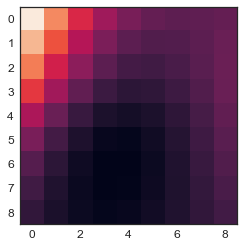

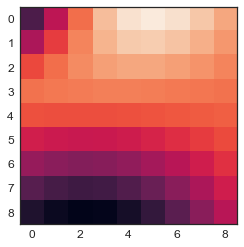

In [83]:

sns.set_style("white")

Kmc = 30

def read_file(f):
    data = pd.read_csv(f, header=None)
    data = data.rename(columns={0: 'time', 1: 'label'})
    for c in data.columns:
        if isinstance(c, int) and ((c % 2) == 1):
            del data[c]
    X = data.values[:,2:]
    X = X.reshape((X.shape[0], 9, 9))[:,:,:,np.newaxis]
    plt.imshow(X[0,:,:,0], interpolation='nearest')
    plt.show()
    y = data.values[:,1,np.newaxis]
    return X, y

train_file = 'data/train_28.5384_-81.3792'
test_file = 'data/test_28.5384_-81.3792'

X_train, Y_train = read_file(train_file)
X_test, Y_test = read_file(test_file)

## Fit Concrete Dropout

$P(X=x) = P(X>0) P(X | X>0) + P(X=0)$  
$P(X=x) = P(X>0) P(X | X>0) $

In [84]:

def normal_loss(true, pred):
    mean = pred[:, :1]
    log_var = pred[:, 1:]         ## log(sigma**2)
    precision = K.exp(-log_var)   ## 1/sigma**2
    return K.sum(precision * (true - mean)**2. + log_var, -1) 

def lognormal_loss(true, pred):
    mean = pred[:, :1]
    log_var = pred[:, 1:]         ## log(sigma**2)
    precision = K.exp(-log_var)   ## 1/sigma**2
    return K.sum(precision * (tf.log(true) - mean)**2. + log_var, -1)  ## log(x) for the log distribution

def gamma_loss(true, pred):
    alpha = K.exp(pred[:, :1])
    beta = K.exp(pred[:, 1:])
    return -(alpha - 1) * K.sum(K.log(true)) + beta * K.sum(true)

def gumbel_loss(true, pred):
    mu = pred[:,:1]
    beta = K.exp(pred[:,1:])
    l = K.sum((true - mu) / beta) + batch_size * K.log(beta)
    l += K.sum(K.exp(-(true - mu)/beta))
    return l

def fit_concrete_climate(nb_epoch, X, Y, output_activation=None, verbose=0,
                        layer_sizes=[128,128], distribution='normal'):

    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = lr**2. / N
    dd = 2. / N
    inp = Input(shape=X.shape[1:])
    x = inp
    for h in layer_sizes:
        x = ConcreteDropout(Conv2D(h, (3,3), padding='valid', activation='relu'), 
                            weight_regularizer=wd, 
                            dropout_regularizer=dd)(x)
    #x = K.reshape(x, (-1, 9*9))
    x = Flatten()(x)

    mean = ConcreteDropout(Dense(1, activation=output_activation), 
                           weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(1), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    loss = normal_loss
    
    #adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, 
    #                       epsilon=1e-08, decay=0.0)
    model.compile(loss=loss, optimizer='adam')

    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    Y_est = model.predict(X)
    hist_loss = hist.history['loss']
    return model, hist_loss  # return ELBO up to const.

def normal_moments(samples):
    """
    Prior distribution is normal
    E[X] = mu
    Var[X] = sigma**2
    """
    mu = samples[:,0].mean(axis=1)
    second_moment = np.zeros(samples.shape[0])
    for k in range(samples.shape[2]):
        sample_var = np.exp(samples[:,1,k])
        sample_mean = samples[:,0,k]
        second_moment += sample_var + mu**2
    
    sigma2 = second_moment / samples.shape[2] - mu**2
    #Y_mean = np.exp(mu + sigma2 / 2.)
    #Y_var = (np.exp(sigma2) - 1) * np.exp(2*mu + sigma2)
    return mu, sigma2

def gumbel_moments(samples):
    '''
    E[X] = mu + beta * 0.5772
    Var[X] = pi**2 beta**2 / 6
    '''
    euler_constant = 0.5772156649
    alpha_samples = samples[:,0]
    beta_samples = np.exp(samples[:,1])
        
    alpha_mean = alpha_samples.mean(axis=1)
    beta_mean = beta_samples.mean(axis=1)
    
    sample_mean = alpha_samples + beta_samples * euler_constant
    sample_var = np.pi**2 * beta_samples**2 / 6.
        
    EX = sample_mean.mean(axis=1)
    EX2 = (sample_var + EX[:,np.newaxis]**2).mean(axis=1)
    VX = EX2 - EX**2
    
    beta_hat = (VX * 6. / (np.pi**2))**0.5
    alpha_hat = EX - beta_hat * euler_constant
    
    return alpha_hat, beta_hat

def heteroskedastic_loss(true, pred):
    mean = pred[:,:1]
    log_var = pred[:,1:]
    precision = K.exp(-log_var)
    return K.sum(precision * (true - mean)**2. + log_var)

def fit_mc(nb_epoch, X, Y, output_activation=None, verbose=0,
           alpha_divergence=False, dropout_prob=default_dropout_rate,
          layer_sizes=layer_sizes):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    D = np.prod(X.shape[1:])
    inp = Input(shape=X.shape[1:])
    x = inp
    #default_dropout_rate = 0.1
    for h in layer_sizes:
        x = KerasMCDropout(Conv2D(h, (3,3), padding='valid', activation='relu'), 
                           dropout_prob=dropout_prob)(x)
    
    x = Flatten()(x)
    mean = KerasMCDropout(Dense(1, activation=output_activation), dropout_prob=dropout_prob)(x)
    log_var = KerasMCDropout(Dense(1), dropout_prob=dropout_prob)(x)
    out = merge([mean, log_var], mode='concat')
        
    model = Model(inp, out)
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)

    if alpha_divergence:
        model.compile(optimizer='adam', loss=alpha_divergence_loss)
    else:
        model.compile(optimizer='adam', loss=heteroskedastic_loss)

    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.


In [85]:
Kmc=10
def alpha_divergence_loss(true, preds, alpha=alpha, D=1., Kmc=Kmc):
    # true: shape (N,K,1)
    # preds of shape (N,K,2)
    # heteroskedastic case
    N = preds.shape[0]
    true = true[:,:,0]  # (N,K)
    mean_samples = preds[:,:,0]     # (N,K)
    log_var_samples = preds[:,:,1]  # (N,K)
    precision = K.exp(-log_var_samples) # (N,K)
    
   # ll = precision/2.*(true - mean_samples)**2. + log_var_samples
    ll = precision *(true - mean_samples)**2. + log_var_samples
    ll = K.sum(K.exp(-alpha * ll), axis=-1) # (N,)
    l = -1/alpha*K.sum(K.log(ll+1e-8))    # float
    #l += K.sum(K.log(precision)) * D / 2.
    return l
    
def split_tensor(x):
    x = [K.expand_dims(_x, 1) for _x in tf.split(x, Kmc, 0)]
    return layers.concatenate(x, axis=1)
    
def fit_alpha(nb_epoch, X, Y, output_activation=None, verbose=0,
           alpha_divergence=False, dropout_prob=default_dropout_rate,
          layer_sizes=layer_sizes, Kmc=Kmc):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    D = np.prod(X.shape[1:])
    inp = Input(shape=X.shape[1:])
    x = inp
    x = layers.concatenate([x for _ in range(Kmc)], axis=0)
    for h in layer_sizes:
        x = KerasMCDropout(Conv2D(h, (3,3), padding='valid', activation='relu'), 
                           dropout_prob=dropout_prob)(x)
    x = Flatten()(x)
    mean = KerasMCDropout(Dense(1, activation=output_activation), dropout_prob=dropout_prob)(x)
    log_var = KerasMCDropout(Dense(1), dropout_prob=dropout_prob)(x)
    out = merge([mean, log_var], mode='concat')

    out = layers.Lambda(split_tensor)(out)
    model = Model(inp, out)
    
    #adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
    #sgd = optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
    
    model.compile(optimizer='adam', loss=alpha_divergence_loss)

    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.



In [88]:
distribution = 'normal'

train_rainy_days = X_train.mean(axis=3).mean(axis=2).mean(axis=1) > 0.0
test_rainy_days = X_test.mean(axis=3).mean(axis=2).mean(axis=1) > 0.0

x_mu = np.mean(X_train[train_rainy_days])
x_std = np.std(X_train[train_rainy_days])
X_train_norm = (X_train - x_mu) / x_std
X_test_norm = (X_test - x_mu) / x_std

Y_train[train_rainy_days] += eps
Y_test[test_rainy_days] += eps

scale_y = StandardScaler().fit(Y_train[train_rainy_days])
Y_train_norm = scale_y.transform(Y_train)

epochs = 20
layer_sizes=[64,]
# Train Concrete

get_samples = lambda model: np.array([model.predict(X_test_norm) for _ in range(Kmc)]).swapaxes(0,1).swapaxes(1,2)

samples = dict()

load = False
if load:
    mc_model = load_model('mc-model.h5', custom_objects={'KerasMCDropout': KerasMCDropout, 
                                                'heteroskedastic_loss': heteroskedastic_loss})
    samples['mc'] = get_samples(mc_model)
    concrete_model = load_model('concrete-model.h5', custom_objects={'ConcreteDropout': ConcreteDropout,
                                                                    'normal_loss': normal_loss})
    samples['concrete'] = get_samples(concrete_model)
    #alpha_model = load_model('alpha-model.h5', custom_objects={'KerasMCDropout': KerasMCDropout,
    #                                                          'alpha_divergence_loss': alpha_divergence_loss})
    #samples['alpha'] = get_samples(alpha_model)
    #alpha_samples = alpha_model.predict(X_test_norm).swapaxes(1,2)
else: 
    
    # Train Models
    '''
    concrete_model, loss = fit_concrete_climate(epochs, X_train_norm, Y_train_norm, 
                output_activation=None, verbose=1, layer_sizes=layer_sizes, 
                distribution=distribution)
    concrete_model.save('concrete-model.h5')
    samples['concrete'] = get_samples(concrete_model)

    mc_model, loss = fit_mc(epochs, X_train_norm, Y_train_norm, alpha_divergence=False,
                output_activation=None, verbose=1, layer_sizes=layer_sizes)
    mc_model.save('mc-model.h5')
    samples['mc'] = get_samples(mc_model)
    '''
    Y_train_norm = Y_train_norm[:,:,np.newaxis]
    Y_train_norm_stack = np.concatenate([Y_train_norm for _ in range(Kmc)], axis=1).astype(np.float32)
    alpha_model, loss = fit_alpha(epochs, X_train_norm.astype(np.float32), Y_train_norm_stack, alpha_divergence=True,
                output_activation=None, verbose=1, layer_sizes=layer_sizes)
    alpha_model.save('alpha-model.h5')
    #alpha_samples = get_samples(alpha_model)
    samples['alpha'] = np.concatenate([alpha_model.predict(X_test_norm).swapaxes(1,2) for _ in range(3)], axis=2)
    print samples['alpha'].shape

/Users/tj/my-env/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Epoch 1/20
8766/8766 [==============================] - 7s - loss: -776.8491     
Epoch 2/20
8766/8766 [==============================] - 6s - loss: -898.7382     
Epoch 3/20
8766/8766 [==============================] - 6s - loss: -933.4898     
Epoch 4/20
8766/8766 [==============================] - 6s - loss: -969.1976     
Epoch 5/20
8766/8766 [==============================] - 7s - loss: -962.4050     
Epoch 6/20
8766/8766 [==============================] - 7s - loss: -993.8752     
Epoch 7/20
8766/8766 [==============================] - 7s - loss: -1013.3945     
Epoch 8/20
8766/8766 [==============================] - 6s - loss: -1019.1166     
Epoch 9/20
8766/8766 [==============================] - 6s - loss: -1032.8403     
Epoch 10/20
8766/8766 [==============================] - 6s - loss: -1034.1827     
Epoch 11/20
8766/8766 [==============================] - 6s - loss: -1013.1956     
Epoch 12/20
8766/8766 [==============================] - 6s - loss: -1035.8140     
Epoch 1

## How good is our coverage?

In [ ]:
import seaborn as sns

## Keep this for later
#if distribution == 'gumbel':
#    alpha, beta = gumbel_moments(Y_samples[test_rainy_days])
#    mu = alpha + beta * 0.5772
#    sigma2 = np.pi**2 / 6. * beta**2

def get_mean_var(samples):
    mu, sigma2 = normal_moments(samples)
    mu = mu * scale_y.var_**0.5 + scale_y.mean_
    sigma2 *= scale_y.var_
    return mu, sigma2

#concrete_mu, concrete_sigma2 = get_mean_var(samples['concrete'][test_rainy_days])
#mc_mu, mc_sigma2 = get_mean_var(samples['mc'][test_rainy_days])
alpha_mu, alpha_sigma2 = get_mean_var(samples['alpha'][test_rainy_days])

get_rmse = lambda x: np.mean((x -  Y_test[test_rainy_days, 0])**2)**0.50

#concrete_rmse = get_rmse(concrete_mu)
alpha_rmse = get_rmse(alpha_mu)
#mc_rmse = get_rmse(mc_mu)
print "RMSE -- ALpha: %2.2f" % (alpha_rmse)
print "RMSE -- Concrete: %2.2f, MC: %2.2f" % (concrete_rmse, mc_rmse)

plt.hist(concrete_sigma2**0.5, bins=50)
plt.show()

In [ ]:
def coverage_plot(samples, y, ax, name=None):
    mu, sigma2 = get_mean_var(samples)
    sigma = np.sqrt(sigma2)
    p_range = np.arange(0.0, 1.0, 0.01)
    ratios = []
    std = sigma2**0.5

    normal_dist = scipy.stats.norm(0,1)
    for p_interval in p_range:
        p = 0.5 + p_interval/2.
        plow = (1. - p)/2
        phi = 1-plow
        
        zscale = normal_dist.ppf(p)
        sample_hi = mu + zscale * std
        sample_low = mu - zscale * std
        
        ratios.append(np.mean((sample_hi > y) & (y > sample_low)))
            
    err = np.mean((p_range - np.array(ratios))**2)**0.5
    ax.plot(p_range, ratios, label='%s - Freq RMSE: %2.2f' % (name.upper(), err))
    
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs = np.ravel(axs)

for key in sorted(samples.keys()):
    coverage_plot(samples[key][test_rainy_days], Y_test[test_rainy_days], axs[0], name=key)
    #coverage_plot(samples[key], Y_test, axs[0], name=key)

axs[0].plot([0,1],[0,1], ls=':')
axs[0].legend()
axs[0].set_title("Uncertainty Calibration")
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Probability")
axs[0].text(-0.1,1.05, 'A)', horizontalalignment='center', verticalalignment='center',
                transform=axs[0].transAxes, fontsize=14)
axs[1].bar([1,2], [mc_rmse, concrete_rmse])
axs[1].set_ylim([5.5,6.5])
axs[1].set_xticks([1,2])
axs[1].set_xticklabels(sorted(samples.keys()))
axs[1].set_title("Predictive Performance")
axs[1].set_ylabel("RMSE (mm/day)")
axs[1].text(-0.1,1.05, 'B)', horizontalalignment='center', verticalalignment='center',
                transform=axs[1].transAxes, fontsize=14)
plt.savefig("uq-results.pdf")
plt.show()


# END of Figures

In [ ]:
idx = np.argsort(rainy_test)[-100]

print rainy_test[idx]
print X_test[test_rainy_days][idx].mean()

m = mu[idx-5:idx+6]
s = np.sqrt(sigma2[idx-5:idx+6])


y_est = []
low, high = [], []
for i in range(len(m)):
    if distribution == 'normal':
        dist = scipy.stats.norm(loc=m[i], scale=np.sqrt(s[i]))
    elif distribution == 'gumbel':
        dist = scipy.stats.gumbel_r(loc=alpha[idx-5:idx+6][i], 
                                    scale=beta[idx-5:idx+6][i])
    y_est += [dist.mean()]
    high += [dist.ppf(0.75)]
    low += [dist.ppf(0.25)]

label = rainy_test[idx-5:idx+6]

plt.figure(figsize=(10,6))
plt.plot(y_est)
plt.plot(label, ls=':')
plt.plot(low, color='green', ls='--')
plt.plot(high, color='red', ls='--')
plt.show()

In [ ]:
cdf = []
for i in np.where(rainy_test > 0.)[0]:
    if distribution == 'gumbel':
        dist = scipy.stats.gumbel_r(loc=alpha[i],scale=beta[i])
    elif distribution == 'normal':
        dist = scipy.stats.norm(loc=mu[i], scale=sigma2[i]**(0.5))
    cdf.append(dist.cdf(Y_test[i])[0])
    
plt.hist(cdf)
plt.xlabel("CDF")